# iCAT Overlay
---
#### Overview
This notebook walks through the procedure for overlaying the fluorescence stacks onto the low magnification EM stacks. Nothing in here is computationally intensive as the registration procedure relies only on the registration metadata created at the time of acquisition. Stacks are specified as `over` (fluorescence channels) or `undr` (low magnification EM)

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up `render-ws` environment
---

In [3]:
import renderapi
from icatapi.render_pandas import create_stacks_DataFrame

In [4]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'zebrafish'
stacks_2_overlay = {
    'over': ['hoechst', 'insulin'],
    'undr': 'big_EM',
}

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)

# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)

# Output
# ------
out = f"""\
all stacks.......... {stacks}
stacks to overlay... {stacks_2_overlay}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = create_stacks_DataFrame(stacks=stacks_2_overlay['over'] +\
                                           [stacks_2_overlay['undr']],
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

all stacks.......... ['lil_EM', 'insulin', 'hoechst', 'big_EM']
stacks to overlay... {'over': ['hoechst', 'insulin'], 'undr': 'big_EM'}
...



tileId     z   width  height   minint   maxint  \
stack                                                                
big_EM  82  aac_big_EM-...  39.0  4096.0  4096.0  29768.0  31413.0   
        75  aad_big_EM-...  37.0  4096.0  4096.0  29583.0  31256.0   
        95  aad_big_EM-...  42.0  4096.0  4096.0  29613.0  31031.0   
hoechst 5   aab_hoechst...  36.0  2048.0  2048.0   8440.0  16880.0   
        25  aab_hoechst...  41.0  2048.0  2048.0   8068.0  16136.0   
        21  aab_hoechst...  40.0  2048.0  2048.0   7810.0  15620.0   
insulin 48  aaa_insulin...  39.0  2048.0  2048.0   4290.0   8580.0   
        37  aab_insulin...  36.0  2048.0  2048.0   4383.0   8766.0   
        55  aad_insulin...  40.0  2048.0  2048.0   4335.0   8670.0   

                  imageUrl          tforms    stack sectionId  imageRow  \
stack                                                                     
big_EM  82  file:///lon...  [M=[[0.9876...   big_EM      S039         0   
        75  file:///lon...  [M=[[0.9876...   big_EM      S037         0   
        95  file:///lon...  [M=[[0.9986...   big_EM      S042         0   
hoechst 5   file:///lon...  [M=[[0.9848...  hoechst      S036         0   
        25  file:///lon...  [M=[[0.9961...  hoechst      S041         0   
        21  file:///lon...  [M=[[0.9902...  hoechst      S040         0   
insulin 48  file:///lon...  [M=[[0.9876...  insulin      S039         0   
        37  file:///lon...  [M=[[0.9848...  insulin      S036         0   
        55  file:///lon...  [M=[[0.9902...  insulin      S040         0   

            imageCol       stageX       stageY  rotation  
stack                                                     
big_EM  82         1 -6498.828000  5753.839000       9.0  
        75         0 -5132.864000  1066.945000       9.0  
        95         0 -6737.448000  5006.570000       3.0  
hoechst 5          2 -4770.782062  1264.566690      10.0  
        25         2 -6390.491000  5234.500000       5.0  
        21         2 -6362.583726  5473.539535       8.0  
insulin 48         3 -6163.633632  5701.194363       9.0  
        37         2 -4770.769062  1264.571690      10.0  
        55         0 -6694.363000  5521.652000       8.0

## Compute overlay transforms
---

### Sample overlay transform

In [5]:
from icatapi.overlay import get_transform_metadata

In [6]:
# Choose random FM image tile filepath
fp = Path(df_project.loc[df_project['stack'].isin(stacks_2_overlay['over'] +\
                                                 [stacks_2_overlay['undr']])]\
                    .sample(1)['imageUrl']\
                    .str.split('://')\
                    .iloc[0][1])

# Test parser
tform_md = get_transform_metadata(fp)
(psx, psy), ro, sh, (trx, try_) = list(tform_md.values())[0]

# Output
out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... ({1e9*psx:.1f}nm, {1e9*psy:.1f}nm)
Rotation...... {np.rad2deg(ro):.1f}°
Shear......... {sh:.2e}
Translation... ({1e6*trx:.1f}um, {1e6*try_:.1f}um)
"""
print(out)

File.......... big_EM/big_EM-00003x00000.tif
Pixel size.... (20.9nm, 20.9nm)
Rotation...... 0.0°
Shear......... -6.67e-03
Translation... (-6238.2um, 4980.3um)



### Compile transform data

In [7]:
from itertools import product

In [8]:
# Create multiindex
overlay_cols = ['stack', 'z', 'sectionId',
                'tileId', 'imageRow', 'imageCol',
                'width', 'height',
                'imageUrl', 'tforms',
                'overlay_transforms']
multiindex = np.array(list(product(overlay_cols,
                                   ['EM', 'FM']))).T.tolist()
# Initialize overlay DataFrame
df_overlay = pd.DataFrame(columns=multiindex)

# Loop through overlay stacks
for stack in stacks_2_overlay['over']:
    # Filter to stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Loop through FM tiles
    for i, FM_tile in df_stack.iterrows():

        # Find correlative EM tile
        EM_tile = df_project.loc[(df_project['stack'] == stacks_2_overlay['undr']) &\
                                 (df_project['z'] == FM_tile['z']) &\
                                 (df_project['imageRow'] == FM_tile['imageRow']) &\
                                 (df_project['imageCol'] == FM_tile['imageCol'])].iloc[0]

        # Build up overlay DataFrame one FM tile at a time
        df_overlay.loc[i, 'stack'] = EM_tile['stack'], FM_tile['stack']
        df_overlay.loc[i, 'z'] = EM_tile['z'], FM_tile['z']
        df_overlay.loc[i, 'sectionId'] = EM_tile['sectionId'], FM_tile['sectionId']
        df_overlay.loc[i, 'tileId'] = EM_tile['tileId'], FM_tile['tileId']
        df_overlay.loc[i, 'imageRow'] = EM_tile['imageRow'], FM_tile['imageRow']
        df_overlay.loc[i, 'imageCol'] = EM_tile['imageCol'], FM_tile['imageCol']
        df_overlay.loc[i, 'width'] = EM_tile['width'], FM_tile['width']
        df_overlay.loc[i, 'height'] = EM_tile['height'], FM_tile['height']
        df_overlay.loc[i, 'imageUrl'] = EM_tile['imageUrl'], FM_tile['imageUrl']
        df_overlay.at[i, ('tforms', 'EM')] = EM_tile['tforms']
        df_overlay.at[i, ('tforms', 'FM')] = FM_tile['tforms']

# Preview
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.sample(5))

stack              z       sectionId                tileId  \
                    EM       FM    EM    FM        EM    FM              EM   
(stack, FM)                                                                   
hoechst     3   big_EM  hoechst  35.0  35.0      S035  S035  aad_big_EM-...   
            13  big_EM  hoechst  38.0  38.0      S038  S038  aab_big_EM-...   
            25  big_EM  hoechst  41.0  41.0      S041  S041  aab_big_EM-...   
            14  big_EM  hoechst  38.0  38.0      S038  S038  aac_big_EM-...   
            1   big_EM  hoechst  35.0  35.0      S035  S035  aab_big_EM-...   
insulin     53  big_EM  insulin  40.0  40.0      S040  S040  aab_big_EM-...   
            38  big_EM  insulin  36.0  36.0      S036  S036  aac_big_EM-...   
            61  big_EM  insulin  42.0  42.0      S042  S042  aab_big_EM-...   
            33  big_EM  insulin  35.0  35.0      S035  S035  aab_big_EM-...   
            56  big_EM  insulin  41.0  41.0      S041  S041  aaa_big_EM-...   

                               imageRow     ...   width          height  \
                            FM       EM FM  ...      EM      FM      EM   
(stack, FM)                                 ...                           
hoechst     3   aad_hoechst...        0  0  ...  4096.0  2048.0  4096.0   
            13  aab_hoechst...        0  0  ...  4096.0  2048.0  4096.0   
            25  aab_hoechst...        0  0  ...  4096.0  2048.0  4096.0   
            14  aac_hoechst...        0  0  ...  4096.0  2048.0  4096.0   
            1   aab_hoechst...        0  0  ...  4096.0  2048.0  4096.0   
insulin     53  aab_insulin...        0  0  ...  4096.0  2048.0  4096.0   
            38  aac_insulin...        0  0  ...  4096.0  2048.0  4096.0   
            61  aab_insulin...        0  0  ...  4096.0  2048.0  4096.0   
            33  aab_insulin...        0  0  ...  4096.0  2048.0  4096.0   
            56  aaa_insulin...        0  0  ...  4096.0  2048.0  4096.0   

                              imageUrl                          tforms  \
                    FM              EM              FM              EM   
(stack, FM)                                                              
hoechst     3   2048.0  file:///lon...  file:///lon...  [M=[[0.9781...   
            13  2048.0  file:///lon...  file:///lon...  [M=[[0.9816...   
            25  2048.0  file:///lon...  file:///lon...  [M=[[0.9961...   
            14  2048.0  file:///lon...  file:///lon...  [M=[[0.9816...   
            1   2048.0  file:///lon...  file:///lon...  [M=[[0.9781...   
insulin     53  2048.0  file:///lon...  file:///lon...  [M=[[0.9902...   
            38  2048.0  file:///lon...  file:///lon...  [M=[[0.9848...   
            61  2048.0  file:///lon...  file:///lon...  [M=[[0.9986...   
            33  2048.0  file:///lon...  file:///lon...  [M=[[0.9781...   
            56  2048.0  file:///lon...  file:///lon...  [M=[[0.9961...   

                               overlay_transforms       
                            FM                 EM   FM  
(stack, FM)                                             
hoechst     3   [M=[[0.9781...             NaN     NaN  
            13  [M=[[0.9816...             NaN     NaN  
            25  [M=[[0.9961...             NaN     NaN  
            14  [M=[[0.9816...             NaN     NaN  
            1   [M=[[0.9781...             NaN     NaN  
insulin     53  [M=[[0.9902...             NaN     NaN  
            38  [M=[[0.9848...             NaN     NaN  
            61  [M=[[0.9986...             NaN     NaN  
            33  [M=[[0.9781...             NaN     NaN  
            56  [M=[[0.9961...             NaN     NaN  

[10 rows x 22 columns]

### Compute overlay transforms

In [9]:
from renderapi.transform import AffineModel
from icatapi.overlay import compute_relative_transform_from_filepaths

In [10]:
# Iterate through CLEM tiles
for i, tile in tqdm(df_overlay.iterrows(), total=len(df_overlay)):

    # Initial translation derived from stage position
    T0_EM = tile[('tforms', 'EM')][-1]
    T0_FM = tile[('tforms', 'FM')][-1]

    # Overlay translation to center tiles
    C0_EM = AffineModel(B0=-tile[('width', 'EM')]/2,
                        B1=-tile[('height', 'EM')]/2)
    C0_FM = AffineModel(B0=-tile[('width', 'FM')]/2,
                        B1=-tile[('height', 'FM')]/2)

    # Compute relative transform
    fp_EM = Path(tile[('imageUrl', 'EM')].split('://')[1])
    fp_FM = Path(tile[('imageUrl', 'FM')].split('://')[1])
    A = AffineModel()
    A.M = compute_relative_transform_from_filepaths(fp_EM, fp_FM)

    # Set overlay transforms
    df_overlay.at[i, ('overlay_transforms', 'EM')] = [C0_EM, T0_EM]
    df_overlay.at[i, ('overlay_transforms', 'FM')] = [C0_FM, A, T0_EM]

# Preview sample overlay transform
sample = df_overlay.sample(1)
out = f"""\
{sample[('tileId', 'EM')].iloc[0]} | \
{sample[('tileId', 'FM')].iloc[0]}
"""
print(out)
sample['overlay_transforms'].values.tolist()

  0%|          | 0/64 [00:00<?, ?it/s]

aab_big_EM-S035-00002x00000 | aab_hoechst-S035-00002x00000



[[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-2048.000000,-2048.000000],
   M=[[0.978148,-0.207912],[0.207912,0.978148]] B=[15553.826993,3074.928345]],
  [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[5.221691,-0.168096],[0.157381,5.297274]] B=[22.062461,-35.204684],
   M=[[0.978148,-0.207912],[0.207912,0.978148]] B=[15553.826993,3074.928345]]]]

## Upload overlaid stacks to `render-ws`
---

### Create overlaid stacks

In [11]:
from renderapi.tilespec import TileSpec

In [12]:
# Collect overlay stacks
stacks_overlaid = []

# Iterate through stacks
for stack in tqdm(stacks_2_overlay['over'] +\
                 [stacks_2_overlay['undr']]):

    # Set overlay stack name
    stack_overlaid = f"{stack}_overlaid"
    stacks_overlaid.append(stack_overlaid)

    # Get stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():

        # Get overlay transforms for each tile from overlay DataFrame
        k = 'FM' if stack in stacks_2_overlay['over'] else 'EM' 
        tile['tforms'] = df_overlay.loc[(df_overlay[('stack', k)] == tile['stack']) &\
                                        (df_overlay[('z', k)] == tile['z']) &\
                                        (df_overlay[('imageRow', k)] == tile['imageRow']) &\
                                        (df_overlay[('imageCol', k)] == tile['imageCol']),
                                        ('overlay_transforms', k)].iloc[0]

        # Create `TileSpec
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Create stack
    renderapi.stack.create_stack(stack_overlaid,
                                 render=render)
    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack_overlaid,
                                      tile_specs,
                                      render=render)
    # Set stack state to complete
    renderapi.stack.set_stack_state(stack_overlaid,
                                    'COMPLETE',
                                    render=render)

  0%|          | 0/3 [00:00<?, ?it/s]

## Inspect overlaid stacks
---

### Tile map

In [13]:
from icatapi.plotting import plot_tile_map, plot_stacks

  0%|          | 0/8 [00:00<?, ?it/s]

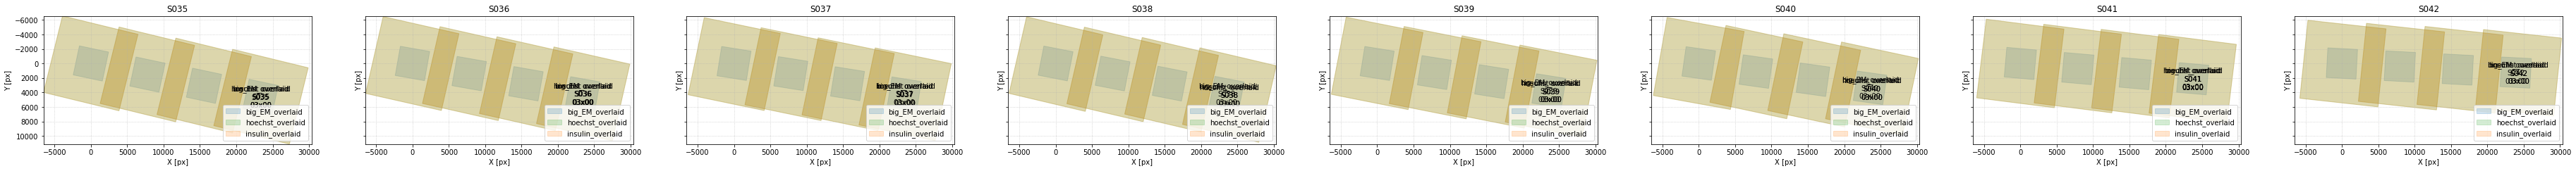

In [14]:
# Choose stacks to plot
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_2_plot = [stack for stack in stacks if 'overlaid' in stack]

# Plot tile maps
plot_tile_map(stacks=stacks_2_plot,
              render=render)

### Render images

  0%|          | 0/24 [00:00<?, ?it/s]

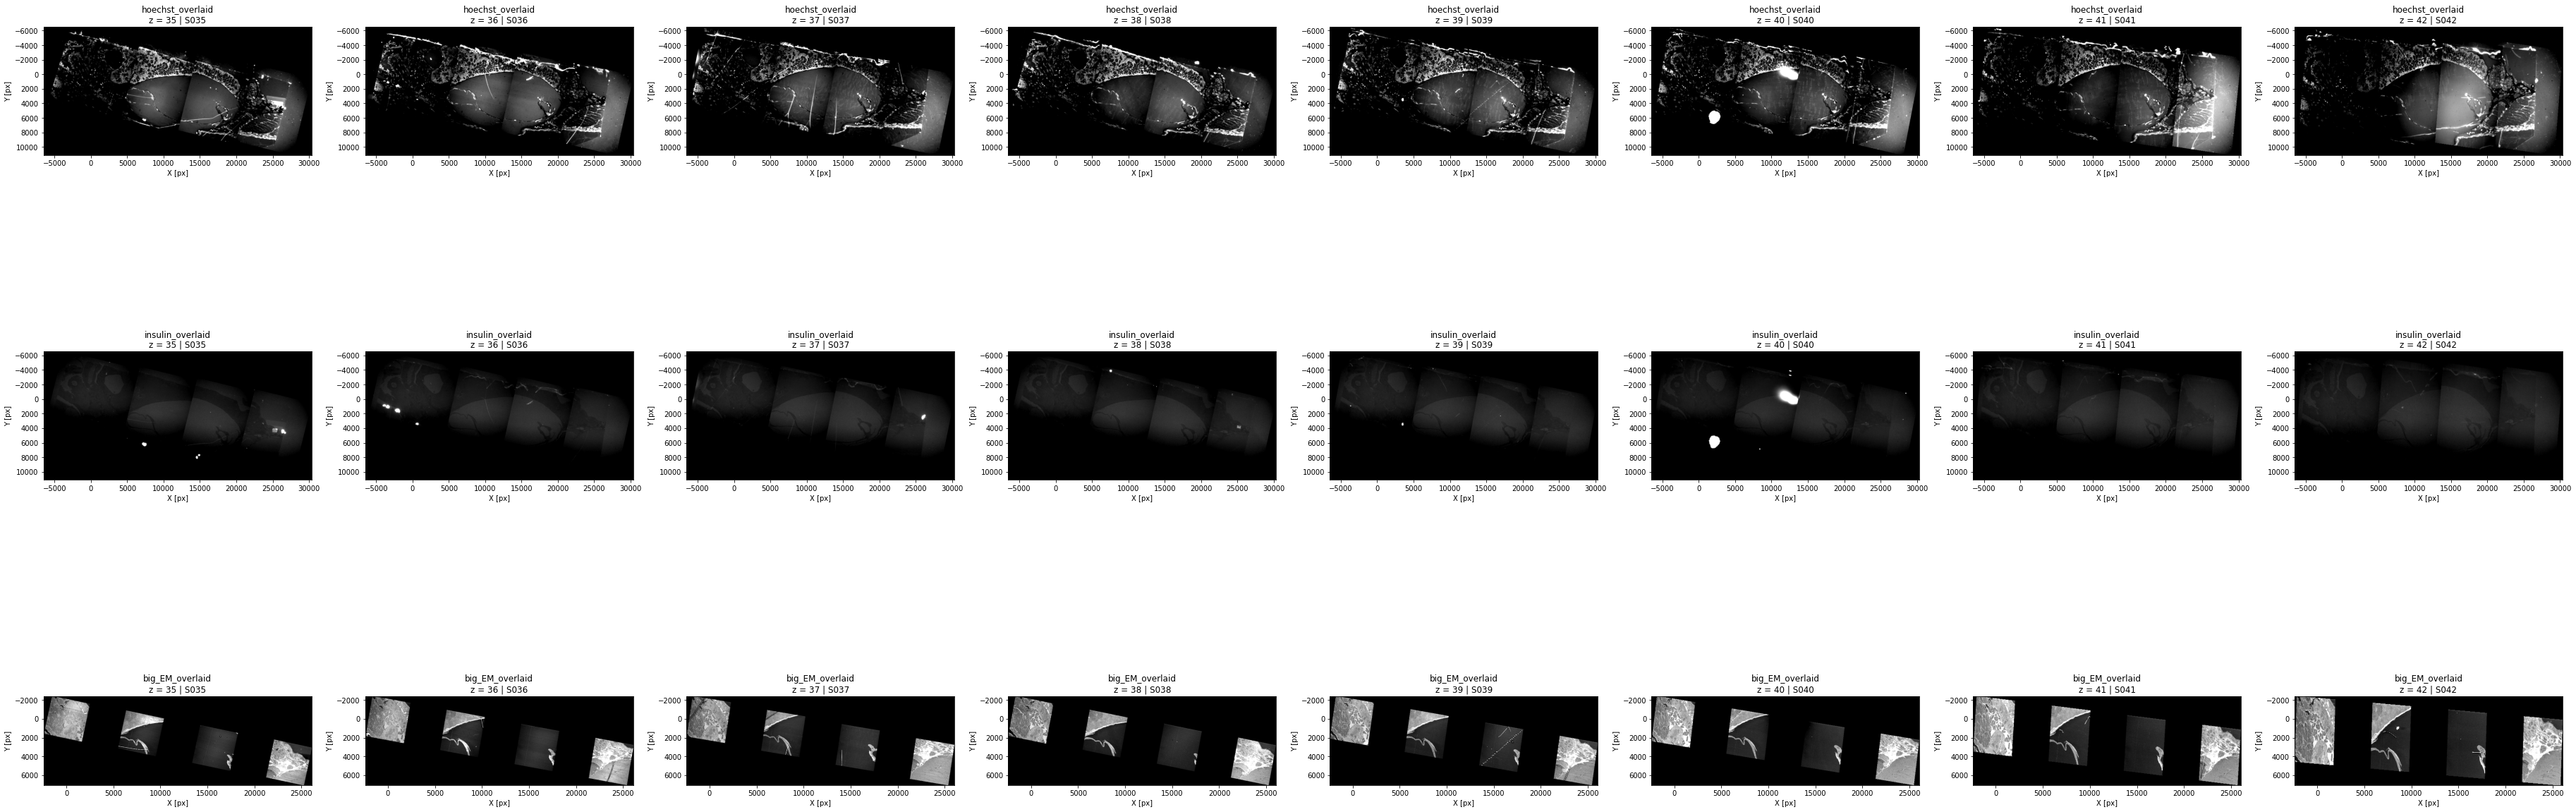

In [15]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid

# Plot stacks
plot_stacks(stacks=stacks_overlaid,
            render=render)